## Section 1: Load Functions 

In [40]:
# This code run the Cyprus LV Network structure that build in pandapower
%run 2.Strovolides_Network.ipynb

# Load the data see for example the following 
%run 4.Load_Data.ipynb

# All the functions that used in modeling
%run 3.Modeling_Functions.ipynb

# All the functions that used in plot section
%run 5.Plot_Functions.ipynb

c:\Users\savva\AppData\Local\anaconda3\Lib\site-packages\pandapower\create.py:4964: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Dyn' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  net[element_type].at[index, column] = value


## Section 2: Testing 
### This section present how some fundemental functions is working by present a data preparation and a single load flow calculation 
#### It was not part of the Monte Carlo simulation it was only for testing purposes 

In [135]:
################## Choose the date that will simulate #######################

month_name="August"
month_to_number = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August":  8,
    "September": 9, "October": 10, "November": 11, "December": 12}
month_number = month_to_number.get(month_name)
days_of_year_in_july = get_days_in_month(month_number)

Load_profile_cyprus[:,days_of_year_in_july]

Simulate_Column = (month_number-1)
pv_p_profile = PV_profile_Cyprus.iloc[:, Simulate_Column]
pv_q_profile = q_pv_profile_cyprus.iloc[:, Simulate_Column]


################## For each feeder randomly create a customer characteristics  #######################

Feeder1Loads = assign_phase_type(df=net.asymmetric_load, three_phase_percentage=0.6,PV_percentage=0.6, EV_percentage=0, Total_loads_of_feeder=50,feeder='F1',values_one_phase=values_one_phase,probabilities_one_phase=probabilities_one_phase,values_three_phase=values_three_phase,probabilities_three_phase=probabilities_three_phase)
F1_Basic_Load = Basic_Load_profile(Feeder1Loads,Type_of_Day=0,load_profile=Load_profile_cyprus)
F1_EV_load = EV_load_profile(Feeder1Loads,0,truncated_normal_arrival,truncated_normal_departure)
F1_load_profile = assign_ev_to_load(Feeder1Loads,F1_Basic_Load,F1_EV_load)

Feeder2Loads = assign_phase_type(df=net.asymmetric_load, three_phase_percentage=0.6,PV_percentage=0.6, EV_percentage=0, Total_loads_of_feeder=50,feeder='F2',values_one_phase=values_one_phase,probabilities_one_phase=probabilities_one_phase,values_three_phase=values_three_phase,probabilities_three_phase=probabilities_three_phase)
F2_Basic_Load = Basic_Load_profile(Feeder2Loads,Type_of_Day=0,load_profile=Load_profile_cyprus)
F2_EV_load = EV_load_profile(Feeder2Loads,0,truncated_normal_arrival,truncated_normal_departure)
F2_load_profile = assign_ev_to_load(Feeder2Loads,F2_Basic_Load,F2_EV_load)

Feeder3Loads = assign_phase_type(df=net.asymmetric_load, three_phase_percentage=0.6,PV_percentage=0.6, EV_percentage=0, Total_loads_of_feeder=50,feeder='F3',values_one_phase=values_one_phase,probabilities_one_phase=probabilities_one_phase,values_three_phase=values_three_phase,probabilities_three_phase=probabilities_three_phase)
F3_Basic_Load = Basic_Load_profile(Feeder3Loads,Type_of_Day=0,load_profile=Load_profile_cyprus)
F3_EV_load = EV_load_profile(Feeder2Loads,0,truncated_normal_arrival,truncated_normal_departure)
F3_load_profile = assign_ev_to_load(Feeder3Loads,F3_Basic_Load,F3_EV_load)

######### Chose time that you want to simulate t=24 refer to 12:00 it was used 30-min interval ########

time=24
power_factor      = 0.97 # For the load
theta = math.acos(power_factor)
tan_theta = math.tan(theta)
net.asymmetric_load= assign_loads(F1_load_profile.iloc[time,:]/1000,(pv_p_profile.iloc[time]/1000), net.asymmetric_load, Feeder1Loads, tan_theta, 0)
net.asymmetric_load= assign_loads(F2_load_profile.iloc[time,:]/1000,(pv_p_profile.iloc[time]/1000), net.asymmetric_load, Feeder2Loads, tan_theta, 0)
net.asymmetric_load= assign_loads(F3_load_profile.iloc[time,:]/1000,(pv_p_profile.iloc[time]/1000), net.asymmetric_load, Feeder3Loads, tan_theta, 0)

In [140]:
##### See some result values #### 

pp.runpp_3ph(net)

print(net.res_bus_3ph.loc[list(Feeder1.values()) + list(Feeder1_load_bus.values()) ]['vm_a_pu'].min())
print(net.res_bus_3ph.loc[list(Feeder1.values()) + list(Feeder1_load_bus.values()) ]['vm_a_pu'].max())

print(net.res_bus_3ph.loc[list(Feeder2.values()) + list(Feeder2_load_bus.values()) ]['vm_a_pu'].min())
print(net.res_bus_3ph.loc[list(Feeder2.values()) + list(Feeder2_load_bus.values()) ]['vm_a_pu'].max())

print(net.res_bus_3ph.loc[list(Feeder3.values()) + list(Feeder3_load_bus.values()) ]['vm_a_pu'].min())
print(net.res_bus_3ph.loc[list(Feeder3.values()) + list(Feeder3_load_bus.values()) ]['vm_a_pu'].max())
print(net.res_trafo_3ph)

## Section 3: Main code 
### Monte Carlo Simulation

#### In each simulated day the data are randomly redefined again 

In [41]:
# Initialize the result dictionary
monte_carlo_total_results = {}

# Some predefined paramters input here: 

power_factor      = 0.97
theta = math.acos(power_factor)
tan_t = math.tan(theta)

# Give Month Name that you want to simulate
month_name = "July"

# Give type of day [weekday = 0], [Weekend = 1]
Type_of_Day = 0

three_phase_perc = 0.8
PV_perc_levels = [0.8] ### Choose the PV Percentage level that you want to add in MC simulation for example [0,0.2,0.4]
loads_per_feeder=50
EV_penetration_levels = [0] ### Choose the EV Percentage level that you want to add in MC simulation for example [0,0.2,0.4]

for PV_perc in PV_perc_levels:
    pv_perc_title = f"monte_carlo_results_pv_{PV_perc}"
    monte_carlo_ev_results = {}
    for EV_perc in EV_penetration_levels:
        ev_perc_title = f"monte_carlo_results_ev_{EV_perc}"
        monte_carlo_results = {}
        for day in range(0, 1):  # Defined here the number of days that you want to add in MC simulation
            print(day)
            results_day  = quasi_sim(net=net,load_profile=Load_profile_cyprus, pv_profile=PV_profile_Cyprus, month_name=month_name, Type_of_Day=Type_of_Day,tan_theta=tan_t,three_phase_percentage=three_phase_perc,PV_percentage=PV_perc,EV_percentage=EV_perc,Total_loads_per_feeder=loads_per_feeder,PV_prob=PV_Proba,Q_Pv_profile=q_pv_profile_cyprus)
            monte_carlo_results[f'day_{day}'] = results_day
        monte_carlo_ev_results[ev_perc_title] = monte_carlo_results
    monte_carlo_total_results[pv_perc_title] = monte_carlo_ev_results

0


## Section 4: Save data
### The result file normally it was more than 2 GB and the simulation time it can be up-to 1 day (depend on parameters and hardware), therefore it recommended to save the results to keep the data in case of kernel restart ###  

In [ ]:

import pickle

# # Save to a .pkl file
# with open('monte_carlo.pkl', 'wb') as file:
#     pickle.dump(monte_carlo_total_results, file)


# # Load from the .pkl file
# with open('Results/3rd_Try/monte_carlo.pkl', 'rb') as file:  # 'rb' stands for read binary
#     monte_carlo_total_results = pickle.load(file)


## Section 5: Plot functions
### here the results that are extracted from the monte carlo simulation plotted

In [25]:
# All the functions that used in plot section
%run 5.Plot_Functions.ipynb

  Median: 0.953
  Lower box-plot: 0.940
  Upper box-plot: 0.976
  Lower Whisker: 0.909
  Upper Whisker: 0.994
  Median: 0.950
  Lower box-plot: 0.924
  Upper box-plot: 0.977
  Lower Whisker: 0.889
  Upper Whisker: 0.995
  Median: 0.957
  Lower box-plot: 0.935
  Upper box-plot: 0.973
  Lower Whisker: 0.920
  Upper Whisker: 0.993


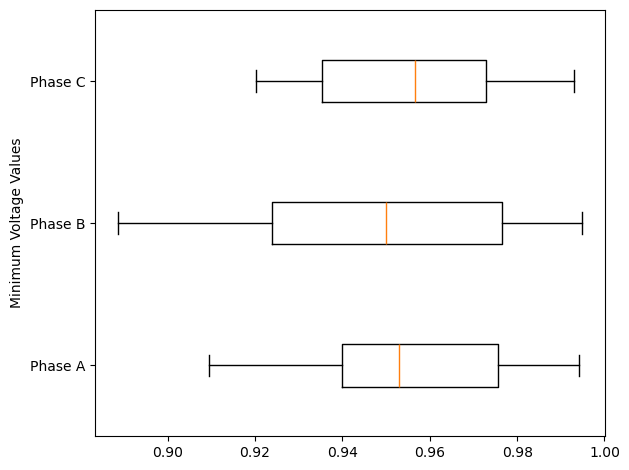

  Median: 1.000
  Lower box-plot: 1.000
  Upper box-plot: 1.005
  Lower Whisker: 1.000
  Upper Whisker: 1.012
  Median: 1.000
  Lower box-plot: 1.000
  Upper box-plot: 1.013
  Lower Whisker: 1.000
  Upper Whisker: 1.027
  Median: 1.000
  Lower box-plot: 1.000
  Upper box-plot: 1.016
  Lower Whisker: 1.000
  Upper Whisker: 1.036


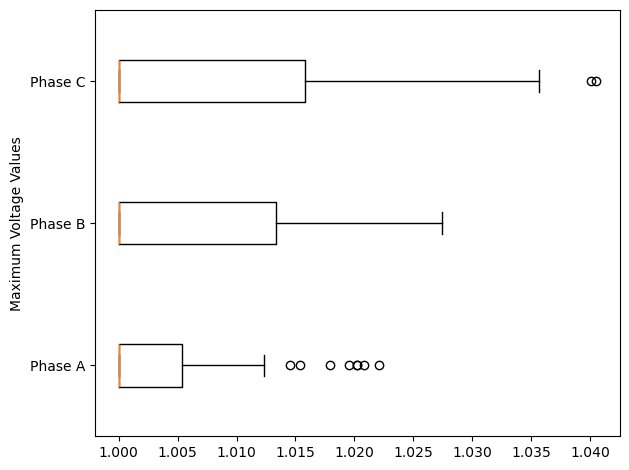

In [26]:
# Specify the PV-EV combination result dataframe to plot min/max box-plot 
# voltage results from all the monte-carlo voltage results

######################## Plot Voltage Results for a certain PV penetration ##########################################################
three_phase_minv_bp_spec(monte_carlo_total_results['monte_carlo_results_pv_0.8']['monte_carlo_results_ev_0'],'Without EVs and 80% PVs')
three_phase_maxv_bp_spec(monte_carlo_total_results['monte_carlo_results_pv_0.8']['monte_carlo_results_ev_0'],'Without EVs and 80% PVs')


  Median: 0.958
  Lower box-plot: 0.936
  Upper box-plot: 0.977
  Lower Whisker: 0.912
  Upper Whisker: 0.994


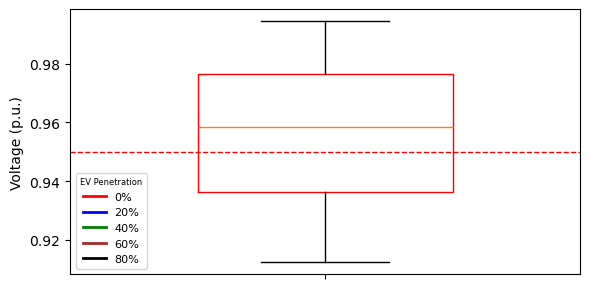

  Median: 1.000
  Lower box-plot: 1.000
  Upper box-plot: 1.008
  Lower Whisker: 1.000
  Upper Whisker: 1.019


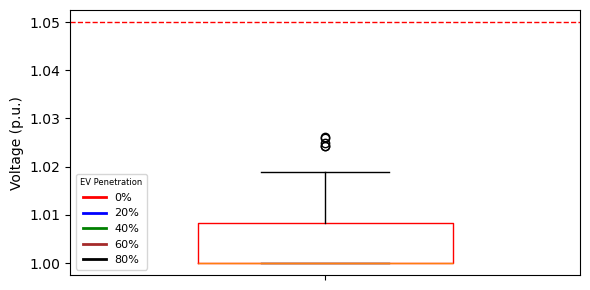

In [37]:
%run 5.Plot_Functions.ipynb
## This function give the avarage voltage value of all EV all PV combinations
min_voltage_bp_general(monte_carlo_total_results,'Minimum Voltage')
max_voltage_bp_general(monte_carlo_total_results,'Maximum Voltage')

  Median: 34.148
  Average: 34.256
  Lower box-plot: 28.312
  Upper box-plot: 43.024
  Lower Whisker: 11.181
  Upper Whisker: 57.150


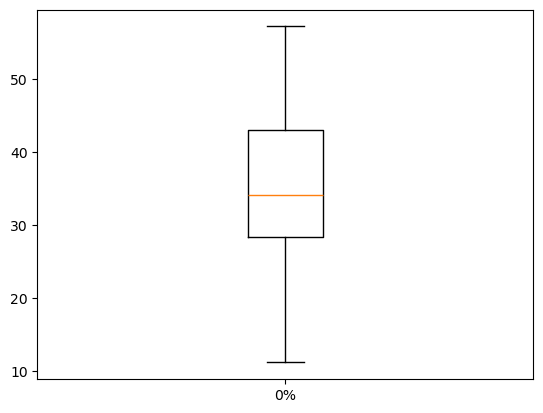

In [ ]:
%run 5.Plot_Functions.ipynb

EV_penetration_levels = [0,0.2,0.4,0.6,0.8]
######################## Plot Transformer Results for a certain PV penetration ##########################################################
# transformer_loading_bp(monte_carlo_total_results['monte_carlo_results_pv_0.2'],EV_penetration_levels,'Transformer loading 2')
transformer_loading_bp(monte_carlo_total_results['monte_carlo_results_pv_0.4'],EV_penetration_levels,'Transformer loading 2')


  Median: 37.94
  Mean: 36.83
  Lower box-plot: 26.79
  Upper box-plot: 47.23
  Lower Whisker: 15.90
  Upper Whisker: 58.45
  Median: 34.15
  Mean: 34.26
  Lower box-plot: 28.31
  Upper box-plot: 43.02
  Lower Whisker: 11.18
  Upper Whisker: 57.15


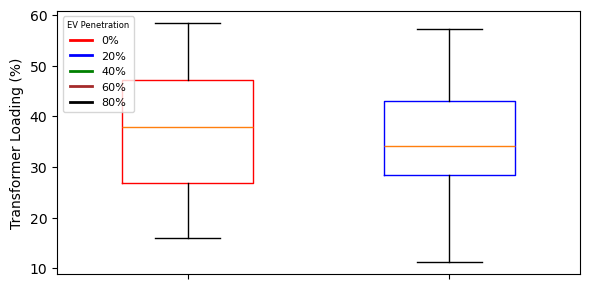

In [59]:

######################## Plot Max Phase Transformer loading Results for a all PV and EV penetration simulations ##########################################################
transformer_loading_bp2(monte_carlo_total_results,'Transformer loading')

  Median: 51.23
  Mean: 52.35
  Lower box-plot: 50.61
  Upper box-plot: 51.24
  Lower Whisker: 50.20
  Upper Whisker: 51.24
  Median: 51.09
  Mean: 51.84
  Lower box-plot: 49.15
  Upper box-plot: 53.95
  Lower Whisker: 47.83
  Upper Whisker: 57.15


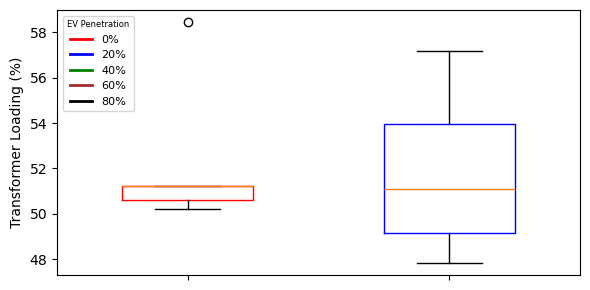

In [60]:
%run 5.Plot_Functions.ipynb
max_transformer_loading_bp2(monte_carlo_total_results,'Max_Transformer loading')

  Median: 17.925
  Lower box-plot: 13.620
  Upper box-plot: 22.256
  Lower Whisker: 7.203
  Upper Whisker: 34.686
  Median: 16.259
  Lower box-plot: 12.566
  Upper box-plot: 20.554
  Lower Whisker: 4.296
  Upper Whisker: 31.439


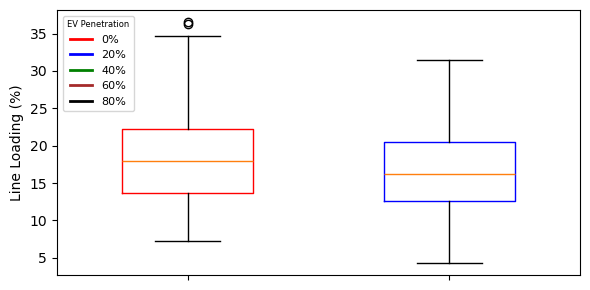

In [61]:
%run 5.Plot_Functions.ipynb
######################## Plot Max Phase line loading Results for a all PV and EV penetration simulations ##########################################################
line_loading_bp2(monte_carlo_total_results,'Line loading')

  Median: 26.536
  Lower box-plot: 23.515
  Upper box-plot: 34.686
  Lower Whisker: 22.937
  Upper Whisker: 36.540
  Median: 25.724
  Lower box-plot: 24.819
  Upper box-plot: 27.146
  Lower Whisker: 24.290
  Upper Whisker: 27.146


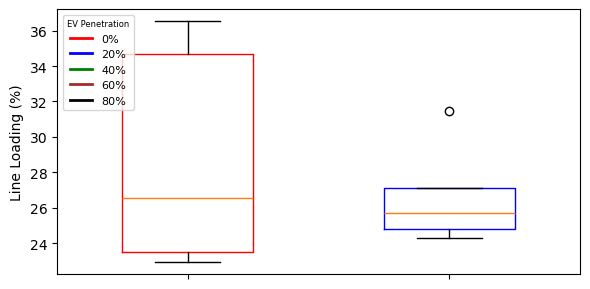

In [62]:
%run 5.Plot_Functions.ipynb
######################## Plot Max Phase line loading Results for a all PV and EV penetration simulations ##########################################################
max_line_loading_bp2(monte_carlo_total_results,'Max Line loading')

  Median: 0.767
  Lower box-plot: 0.424
  Upper box-plot: 1.746
  Lower Whisker: 0.140
  Upper Whisker: 3.676
  Median: 0.573
  Lower box-plot: 0.394
  Upper box-plot: 0.857
  Lower Whisker: 0.141
  Upper Whisker: 1.534


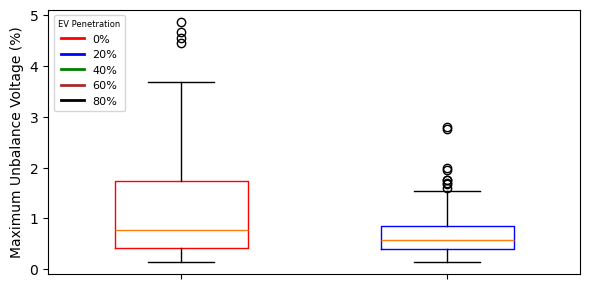

In [63]:
max_unbalance_voltage_bp2(monte_carlo_total_results,'Voltage Unbalance')

  Median: 44.182
  Lower box-plot: 43.165
  Upper box-plot: 44.293
  Lower Whisker: 43.030
  Upper Whisker: 44.293
  Median: 40.641
  Lower box-plot: 40.385
  Upper box-plot: 42.195
  Lower Whisker: 40.022
  Upper Whisker: 42.195
  Median: 40.899
  Lower box-plot: 40.867
  Upper box-plot: 41.748
  Lower Whisker: 40.479
  Upper Whisker: 41.748
  Median: 38.644
  Lower box-plot: 38.008
  Upper box-plot: 38.739
  Lower Whisker: 37.972
  Upper Whisker: 38.739
  Median: 37.901
  Lower box-plot: 37.436
  Upper box-plot: 38.840
  Lower Whisker: 35.623
  Upper Whisker: 38.840
  Median: 36.706
  Lower box-plot: 34.759
  Upper box-plot: 36.766
  Lower Whisker: 34.163
  Upper Whisker: 36.766
  Median: 35.249
  Lower box-plot: 34.990
  Upper box-plot: 35.918
  Lower Whisker: 34.990
  Upper Whisker: 35.918
  Median: 37.273
  Lower box-plot: 35.595
  Upper box-plot: 42.156
  Lower Whisker: 34.300
  Upper Whisker: 46.366
  Median: 35.309
  Lower box-plot: 33.573
  Upper box-plot: 43.323
  Lower Whisk

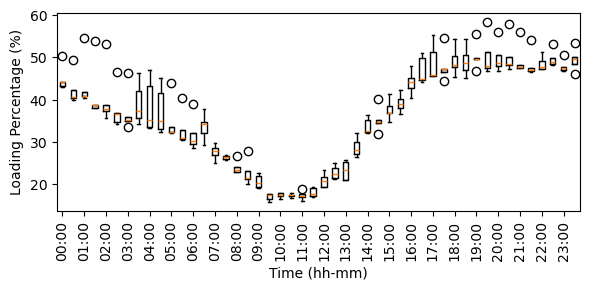

In [65]:
%run 5.Plot_Functions.ipynb
######################## Plot time interval transformer loading Results for a certain PV and EV penetration ##########################################################
transformer_loading_time_interval_boxplot(monte_carlo_total_results['monte_carlo_results_pv_0.2']['monte_carlo_results_ev_0'],'Transformer Loading Without EV')


  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 0.000
  Lower box-plot: 0.000
  Upper box-plot: 0.000
  Lower Whisker: 0.000
  Upper Whisker: 0.000
  Median: 

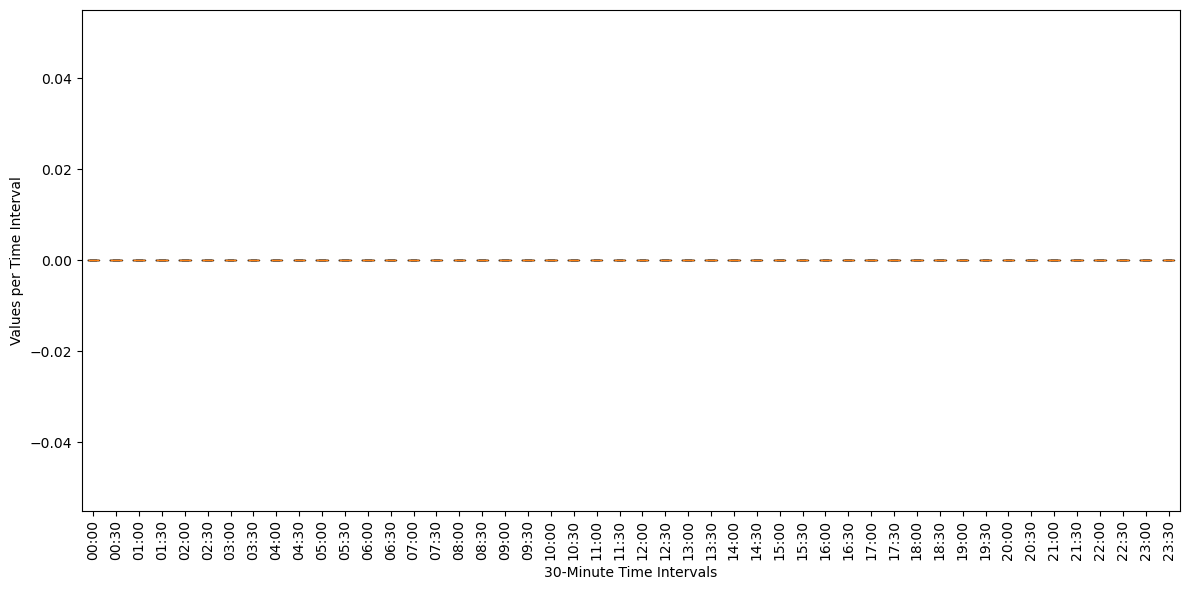

In [66]:
######################## Plot time interval EV loading profile  for a certain PV and EV penetration ##########################################################
ev_loading_time_interval_boxplot(monte_carlo_total_results['monte_carlo_results_pv_0.2']['monte_carlo_results_ev_0'],'Without EV')

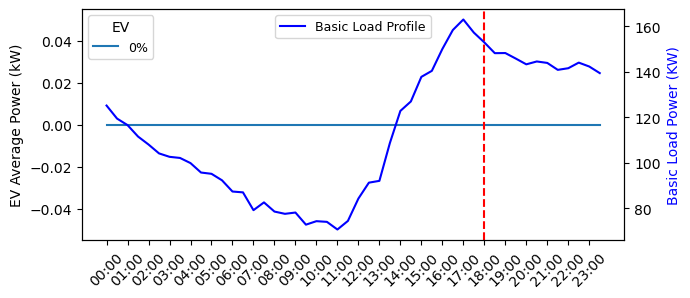

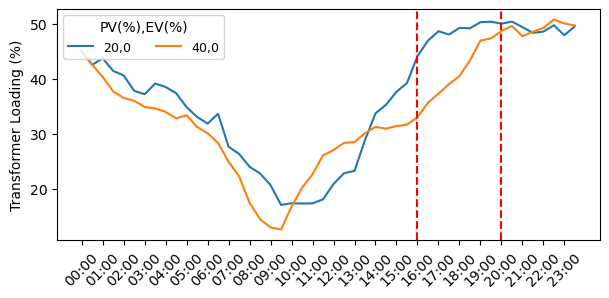

In [67]:
%run 5.Plot_Functions.ipynb
mean_ev_and_trans_loading_time_interval_lineplot(monte_carlo_total_results,Strovolides_Loads_Measurement['P_Sum'],'Average EV Profile and Transformer Loading')

In [69]:
groups,groupF1,groupF2,groupF3 = group_buses_results_by_distance(net)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


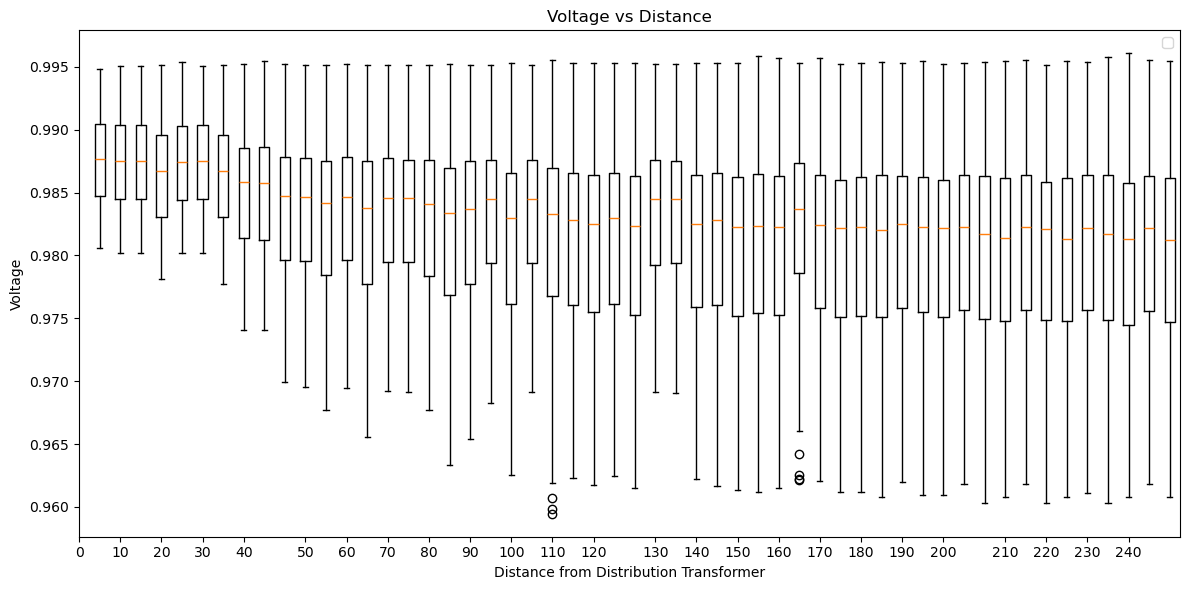

In [71]:
distance_voltage_bp(monte_carlo_total_results['monte_carlo_results_pv_0.4']['monte_carlo_results_ev_0'],'Voltage vs Distance',groupF3)

In [137]:
%run 5.Plot_Functions.ipynb
distance_voltage_lineplot(([monte_carlo_total_results['monte_carlo_results_pv_0.2']['monte_carlo_results_ev_0'],monte_carlo_total_results['monte_carlo_results_pv_0.4']['monte_carlo_results_ev_0']]),'Mean Voltage Deviation Over Distance From Substation',[groupF1,groupF2,groupF3])

NameError: name 'monte_carlo_total_results' is not defined